In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("azminetoushikwasi/supplygraph-supply-chain-planning-using-gnns")

# print("Path to dataset files:", path)

In [2]:
import pandas as pd
path = "./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/"

# Nodes
nodes = pd.read_csv(path + "Nodes/Nodes.csv")   
edges = pd.read_csv(path + "Edges/Edges (Plant).csv")

delivery_to_distributor = pd.read_csv(path + "Temporal Data/Unit/Delivery To distributor.csv")
factory_issue = pd.read_csv(path + "Temporal Data/Unit/factory issue.csv")
production = pd.read_csv(path + "Temporal Data/Unit/Production .csv")
sales_order = pd.read_csv(path + "Temporal Data/Unit/Sales order.csv")



In [3]:
import pandas as pd
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

path = "./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/Temporal Data/Unit/"

production = pd.read_csv(path + "Production .csv")
factory_issue = pd.read_csv(path + "factory issue.csv")
delivery = pd.read_csv(path + "Delivery To distributor.csv")
sales_order = pd.read_csv(path + "Sales order.csv")

products = [col for col in production.columns if col != "Date"]
product_to_id = {prod: i for i, prod in enumerate(products)}

def transform_temporal(df, mapping):
    df_no_date = df.drop(columns=["Date"])
    return df_no_date.rename(columns=mapping)

X_prod = transform_temporal(production, product_to_id)
X_issue = transform_temporal(factory_issue, product_to_id)
X_delivery = transform_temporal(delivery, product_to_id)
X_sales = transform_temporal(sales_order, product_to_id)  

X_prod_np = X_prod.to_numpy()
X_issue_np = X_issue.to_numpy()
X_delivery_np = X_delivery.to_numpy()
X_sales_np = X_sales.to_numpy()

# shape: [T, N, F] = [time_steps, num_nodes, num_features]
X = np.stack([X_prod_np, X_issue_np, X_delivery_np, X_sales_np], axis=-1)

y = X_sales_np[1:]       
X = X[:-1]

print("X shape:", X.shape)  # (T-1, N, 4)
print("y shape:", y.shape)  # (T-1, N)


X shape: (220, 41, 4)
y shape: (220, 41)


In [4]:
X = X[:110]
X.shape
y = y[:110]

In [5]:
train = int(0.8 * X.shape[0])

X_train, X_test = X[:train], X[train:]
y_train, y_test = y[:train], y[train:]

In [6]:
from sklearn.preprocessing import StandardScaler

# Flatten for scaling: combine time and nodes
T, N, F = X_train.shape
X_flat = X_train.reshape(-1, F)  # shape [T*N, F]
y_flat = y_train.reshape(-1, 1)  # shape [T*N, 1]

# Create scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform
X_train_scaled_flat = scaler_X.fit_transform(X_flat)
y_train_scaled_flat = scaler_y.fit_transform(y_flat)

# Reshape back to original shape
X_train_scaled = X_train_scaled_flat.reshape(T, N, F)
y_train_scaled = y_train_scaled_flat.reshape(T, N)

print(f"X_scaled range: {X_train_scaled.min():.2f} to {X_train_scaled.max():.2f}")
print(f"y_scaled range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")


X_scaled range: -0.43 to 9.22
y_scaled range: -0.35 to 9.32


In [7]:
y_test_flat = y_test.reshape(-1, 1)
y_test_scaled_flat = scaler_y.transform(y_test_flat)
y_test_scaled = y_test_scaled_flat.reshape(y_test.shape)

X_test_flat = X_test.reshape(-1, F)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

T, N, F = X_train.shape

# Prepare scaled containers
X_train_scaled = np.zeros_like(X_train)
y_train_scaled = np.zeros_like(y_train)
X_test_scaled = np.zeros_like(X_test)
y_test_scaled = np.zeros_like(y_test)

scaler_X_per_product = []
scaler_y_per_product = []

for node_idx in range(N):
    # Fit a scaler for features of this product
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_node = X_train[:, node_idx, :]  # (T, F)
    y_node = y_train[:, node_idx].reshape(-1, 1)
    
    X_train_scaled[:, node_idx, :] = scaler_X.fit_transform(X_node)
    y_train_scaled[:, node_idx] = scaler_y.fit_transform(y_node).ravel()
    
    # Scale test data using same scaler
    X_test_scaled[:, node_idx, :] = scaler_X.transform(X_test[:, node_idx, :])
    y_test_scaled[:, node_idx] = scaler_y.transform(y_test[:, node_idx].reshape(-1, 1)).ravel()
    
    scaler_X_per_product.append(scaler_X)
    scaler_y_per_product.append(scaler_y)


In [9]:
edges = pd.read_csv("./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/Edges/Edges (Product Group).csv")

edges['node1'] = edges['node1'].astype(str)
edges['node2'] = edges['node2'].astype(str)

edges['node1'] = edges['node1'].map(product_to_id)
edges['node2'] = edges['node2'].map(product_to_id)

edge_index = edges[['node1', 'node2']].to_numpy().T.astype(np.int64)

num_nodes = len(product_to_id)

train_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_train_scaled,
    targets=y_train_scaled
)

test_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_test_scaled,
    targets=y_test_scaled
)


In [10]:
# from torch_geometric_temporal.signal import temporal_signal_split

# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.7)

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GCLSTM

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h=None, c=None):
        # Pass previous hidden states (if any)
        h, c = self.recurrent(x, edge_index, edge_weight, h, c)
        out = F.relu(h)
        out = self.linear(out)
        return out.squeeze(-1), (h, c)

In [12]:
model = RecurrentGCN(node_features=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
from tqdm import tqdm

def calculate_mse(model, dataset):
    model.eval()
    total_loss = 0.0
    h, c = None, None
    with torch.no_grad():
        for time, snapshot in enumerate(dataset):
            y_hat, (h, c) = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            total_loss += torch.mean((y_hat - snapshot.y) ** 2).item()
    return total_loss / (time + 1)


gclstm_train_mse = []
gclstm_test_mse = []

n_epoch = 100

for epoch in tqdm(range(n_epoch)):
    model.train()
    total_loss = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        optimizer.zero_grad()
        y_hat, (h, c) = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        loss = torch.mean((y_hat - snapshot.y) ** 2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        h = h.detach()
        c = c.detach()

    
    train_mse = calculate_mse(model, train_dataset)
    test_mse = calculate_mse(model, test_dataset)
    gclstm_train_mse.append(train_mse)
    gclstm_test_mse.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epoch} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}")



 10%|█         | 10/100 [00:05<00:45,  1.98it/s]

Epoch 10/100 | Train MSE: 0.9067 | Test MSE: 0.6727


 20%|██        | 20/100 [00:11<00:54,  1.48it/s]

Epoch 20/100 | Train MSE: 0.8932 | Test MSE: 0.6578


 30%|███       | 30/100 [00:17<00:45,  1.55it/s]

Epoch 30/100 | Train MSE: 0.8751 | Test MSE: 0.6655


 40%|████      | 40/100 [00:24<00:41,  1.45it/s]

Epoch 40/100 | Train MSE: 0.8707 | Test MSE: 0.6625


 50%|█████     | 50/100 [00:31<00:37,  1.35it/s]

Epoch 50/100 | Train MSE: 0.8691 | Test MSE: 0.6731


 60%|██████    | 60/100 [00:39<00:28,  1.41it/s]

Epoch 60/100 | Train MSE: 0.8620 | Test MSE: 0.6758


 70%|███████   | 70/100 [00:46<00:22,  1.34it/s]

Epoch 70/100 | Train MSE: 0.8637 | Test MSE: 0.6783


 80%|████████  | 80/100 [00:54<00:14,  1.35it/s]

Epoch 80/100 | Train MSE: 0.8537 | Test MSE: 0.6804


 90%|█████████ | 90/100 [01:00<00:06,  1.50it/s]

Epoch 90/100 | Train MSE: 0.8567 | Test MSE: 0.7148


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

Epoch 100/100 | Train MSE: 0.9059 | Test MSE: 0.7093


In [18]:
# SIMPLE LSTM
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x, h=None, c=None):
        # x shape: (batch_size, seq_len, input_size)
        out, (h_n, c_n) = self.lstm(x, (h, c))
        predictions = self.linear(out[:, -1, :])
        return predictions.squeeze(-1), (h_n, c_n)

In [19]:
def prepare_lstm_data(X, y):
    T, N, F = X.shape
    X_lstm = X.reshape(T * N, 1, F)  # (T*N, seq_len=1, features)
    y_lstm = y.reshape(T * N)
    return torch.FloatTensor(X_lstm), torch.FloatTensor(y_lstm)
    

X_train_lstm, y_train_lstm = prepare_lstm_data(X_train_scaled, y_train_scaled)
X_test_lstm, y_test_lstm = prepare_lstm_data(X_test_scaled, y_test_scaled)

print(f"LSTM Train X shape: {X_train_lstm.shape}")
print(f"LSTM Train y shape: {y_train_lstm.shape}")

LSTM Train X shape: torch.Size([3608, 1, 4])
LSTM Train y shape: torch.Size([3608])


In [20]:
lstm_model = SimpleLSTM(input_size=4, hidden_size=32, num_layers=1)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()

In [21]:
n_epoch = 100
lstm_train_losses = []
lstm_test_losses = []

for epoch in tqdm(range(n_epoch)):

    h, c = None, None

    # Training
    lstm_model.train()
    lstm_optimizer.zero_grad()
    y_pred, (h, c) = lstm_model(X_train_lstm, h, c)
    train_loss = criterion(y_pred, y_train_lstm)
    train_loss.backward()
    lstm_optimizer.step()
    
    # Evaluate every epoch
    lstm_model.eval()
    with torch.no_grad():
        y_test_pred = lstm_model(X_test_lstm)
        test_loss = criterion(y_test_pred, y_test_lstm)
    
    lstm_train_losses.append(train_loss.item())
    lstm_test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epoch} | Train MSE: {train_loss.item():.4f} | Test MSE: {test_loss.item():.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'dim'

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

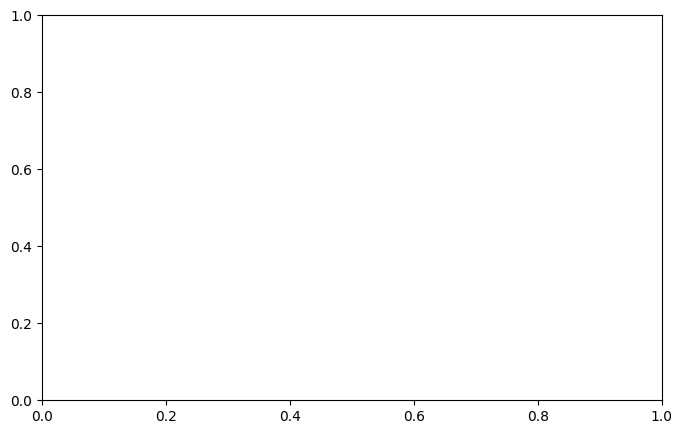

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epoch+1), lstm_test_losses, label="LSTM Test MSE", color="orange")
plt.plot(range(1, n_epoch+1), gclstm_test_mse, label="GCLSTM Test MSE", color="blue")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Sales Forecasting Comparison: LSTM vs GCLSTM")
plt.legend()
plt.grid(True)
plt.show()